definition batch normalization layer

- [TensorFlow](https://www.tensorflow.org/api_docs)
- [Tensor 기본 연산 코드 참고](https://www.tensorflow.org/api_docs/python/tf/TensorArray)
- 구성 함수 참고: [TensorFlow numpy.append](https://www.tensorflow.org/api_docs/python/tf/experimental/numpy/append), [W3cubDocs](https://docs.w3cub.com/tensorflow~python/tf/keras/backend/std)
- Layer 구성 참고: [TensorFlow's 사용자 정의 층](https://www.tensorflow.org/tutorials/customization/custom_layers?hl=ko), [TensorFlow's 하위 클래스화를 통한 새로운 레이어 및 모델 만들기](https://www.tensorflow.org/guide/keras/custom_layers_and_models?hl=ko)
- [뉴런층의 출력 확인하기](https://codetorial.net/tensorflow/get_output_of_neuron_layers.html)

<br />

- 현재는 batch에 정규화만 진행했기 때문에, test할 때 이전 값들을 이용하는 것 없음.
- channel에 대한 정규화 값을 확인하지 않았음. (그래서 연산 안 될 수도)
- TF's batch normalization이랑 비교해야 함.
- Deep Learning with Python's 5.4 파트에서 layer output 시각화에 대한 이야기를 하고 있음.

In [1]:
# data for check
import numpy as np
from tensorflow.keras.datasets.mnist import load_data

# model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Layer, Conv2D, Flatten, Dense
from tensorflow.keras.backend import mean, std
from tensorflow.keras.callbacks import EarlyStopping

# visualization
import matplotlib.pyplot as plt

### load data

In [2]:
(train, trainl), (test, testl) = load_data()

In [3]:
train = (train.astype("float32") / 255.0).reshape((len(train), len(test[0]), len(test[1]), -1))
test = (test.astype("float32") / 255.0).reshape((len(test), len(test[0]), len(test[1]), -1))

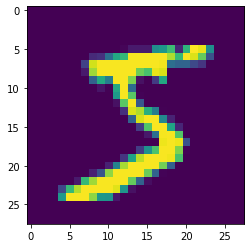

In [4]:
plt.imshow(train[0])

### make custom layer

In [5]:
tf.config.run_functions_eagerly(True)
class batch_normalization(Layer):
    def __init__(self, num_outputs, **kwargs):
        super(batch_normalization, self).__init__(**kwargs)
        self.num_outputs = num_outputs
        self.means = []
        self.stds = []

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])

    @tf.function
    def call(self, inputs, training=None):
        if training:
            d_mean = mean(inputs)
            d_std = std(inputs)

            self.means.append(d_mean.numpy())
            self.stds.append(d_std.numpy())
        else:
            d_mean = np.mean(self.means)
            d_std = np.mean(self.stds)

        hiddens = (inputs - d_mean) / d_std
        return tf.matmul(hiddens, self.kernel)

    def check_values(self):
        return self.means, self.stds

### build model

#### w/o

In [6]:
np.random.seed(3)
tf.random.set_seed(3)

In [7]:
wo_early = EarlyStopping(monitor="val_loss", patience=5)

In [8]:
wo_model = Sequential()
wo_model.add(Conv2D(32, kernel_size=3, input_shape=(28, 28, 1), activation="relu"))
wo_model.add(Conv2D(16, kernel_size=3, activation="relu"))
wo_model.add(Flatten())
wo_model.add(Dense(10, activation="softmax"))

In [9]:
wo_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [10]:
wo_history = wo_model.fit(train, trainl, validation_split=0.3, batch_size=100, epochs=30, callbacks=[wo_early])

X:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
420/420 [==============================] - 9s 15ms/step - loss: 0.2659 - accuracy: 0.9243 - val_loss: 0.1064 - val_accuracy: 0.9691
Epoch 2/30
420/420 [==============================] - 6s 14ms/step - loss: 0.0804 - accuracy: 0.9767 - val_loss: 0.0762 - val_accuracy: 0.9777
Epoch 3/30
420/420 [==============================] - 6s 14ms/step - loss: 0.0572 - accuracy: 0.9825 - val_loss: 0.0768 - val_accuracy: 0.9774
Epoch 4/30
420/420 [==============================] - 6s 14ms/step - loss: 0.0432 - accuracy: 0.9866 - val_loss: 0.0694 - val_accuracy: 0.9789
Epoch 5/30
420/420 [==============================] - 6s 14ms/step - loss: 0.0340 - accuracy: 0.9897 - val_loss: 0.0690 - val_accuracy: 0.9813
Epoch 6/30
420/420 [==============================] - 6s 14ms/step - loss: 0.0254 - accuracy: 0.9922 - val_loss: 0.0727 - val_accuracy: 0.9803
Epoch 7/30
420/420 [==============================] - 6s 14ms/step - loss: 0.0222 - accuracy: 0.9930 - val_loss: 0.0693 - val_accuracy: 0.9815

#### with custom

In [11]:
np.random.seed(3)
tf.random.set_seed(3)

In [12]:
early = EarlyStopping(monitor="val_loss", patience=5)

In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, input_shape=(28, 28, 1), activation="relu"))
model.add(batch_normalization(32))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

X:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
X:\Program Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (batch_n (None, 26, 26, 32)        1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                92170     
Total params: 98,138
Trainable params: 98,138
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
history = model.fit(train, trainl, validation_split=0.3, batch_size=100, epochs=30, callbacks=[early])

Epoch 1/30
420/420 [==============================] - 9s 20ms/step - loss: 0.1910 - accuracy: 0.9446 - val_loss: 0.0864 - val_accuracy: 0.9746
Epoch 2/30
420/420 [==============================] - 10s 23ms/step - loss: 0.0637 - accuracy: 0.9807 - val_loss: 0.0730 - val_accuracy: 0.9773
Epoch 3/30
420/420 [==============================] - 11s 27ms/step - loss: 0.0397 - accuracy: 0.9869 - val_loss: 0.0844 - val_accuracy: 0.9747
Epoch 4/30
420/420 [==============================] - 13s 30ms/step - loss: 0.0302 - accuracy: 0.9899 - val_loss: 0.0870 - val_accuracy: 0.9757
Epoch 5/30
420/420 [==============================] - 14s 33ms/step - loss: 0.0211 - accuracy: 0.9927 - val_loss: 0.0891 - val_accuracy: 0.9785
Epoch 6/30
420/420 [==============================] - 15s 36ms/step - loss: 0.0168 - accuracy: 0.9944 - val_loss: 0.0913 - val_accuracy: 0.9783
Epoch 7/30
420/420 [==============================] - 17s 40ms/step - loss: 0.0149 - accuracy: 0.9951 - val_loss: 0.0917 - val_accuracy: 

### result

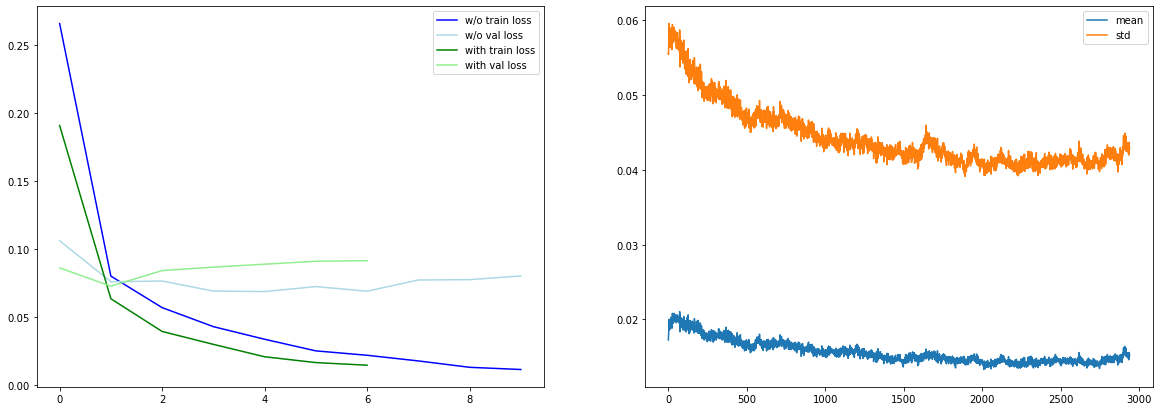

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(wo_history.epoch, wo_history.history["loss"], c="blue", label="w/o train loss")
ax[0].plot(wo_history.epoch, wo_history.history["val_loss"], c="lightblue", label="w/o val loss")

ax[0].plot(history.epoch, history.history["loss"], c="green", label="with train loss")
ax[0].plot(history.epoch, history.history["val_loss"], c="lightgreen", label="with val loss")

means, stds = model.layers[1].check_values()
ax[1].plot(means, label="mean")
ax[1].plot(stds, label="std")

for i in range(2):
    ax[i].legend(loc="best")
plt.show()

In [18]:
print("w/o Accuracy:\t%.4f" % wo_model.evaluate(test, testl)[1],
      "with Accuracy:\t%.4f" % model.evaluate(test, testl)[1], sep="\n")

313/313 [==============================] - 8s 26ms/step - loss: 0.0834 - accuracy: 0.9810
w/o Accuracy:	0.9846
with Accuracy:	0.9810


|   | without | with (custom)
|:-:|:-:|:-:|
걸린 시간 | 1분 3.8초 (10 epoch) | 1분 28.2초 (7 epoch) |
loss 초기 / 마지막 | 0.2659 / 0.117 | 0.1910 / 0.0149 |
val loss 초기 / 마지막 | 0.1064 / 0.0805 | 0.0864 / 0.0917 |
test accuracy | 0.9846 | 0.9810 |

- 더 적은 epoch으로 수렴한다는 측면에서 (제대로 만든 건지는 모르겠지만) batch normalization이 효과가 있어 보임.
- best 모델을 기준으로 하면 custom layer를 가진 모델이 train loss, validation loss 모두 작아서 test accuracy가 더 나아질 가능성이 있어 보임.
<!-- - 사실 지금 batch size 작아보임. -->